**Étapes pour utiliser le code :**

1. Préparez votre dataset comme décrit, avec les images dans un dossier et le fichier CSV des labels.

2. Mettez à jour les variables DATA_DIR, CSV_FILE, IMAGE_DIR, et surtout la liste EMOTION_LABELS pour qu'elle corresponde exactement à vos émotions et l'ordre de vos colonnes dans le CSV.

3. Exécutez le script.

4. Surveillez la console pour les métriques d'entraînement et de validation. Ajustez les hyperparamètres (BATCH_SIZE, NUM_EPOCHS, LEARNING_RATE, FREEZE_FEATURES) si nécessaire en fonction des performances observées.

**Organisation des données :**

your_dataset/

├── images/

│   ├── image_001.jpg

│   ├── image_002.jpg

│   └── ...

└── labels.csv # Ou un autre format de fichier, contenant les chemins d'images et leurs étiquettes

**Format du dataset :**

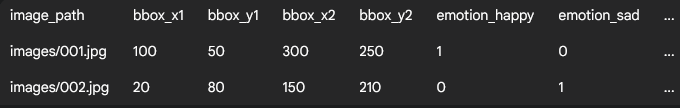

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models#, transforms
import torchvision.transforms.v2 as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import os
import time
import copy
import onnx
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, mean_squared_error
from sklearn.metrics import classification_report
import numpy as np
from tqdm import tqdm # Pour les barres de progression

#import matplotlib.pyplot as plt

In [2]:
torch.__version__

'2.5.1+cu121'

On a le choix de fine tuner la dernière couche OU tout le modele (pas le même temps)

# I/ Configuration et Hyperparamètres 

In [3]:
# --- 0. Configuration et Hyperparamètres ---
DATA_DIR = r'C:\Users\alber\Desktop\visual_studio_code\dossier_jedha\Jedha_Full_stack\00_Final_Project\emotic' # Chemin vers votre dossier racine du dataset
CSV_FILE = os.path.join(DATA_DIR, 'labels_v2.csv') # Chemin vers votre fichier CSV d'étiquettes
IMAGE_DIR = os.path.join(DATA_DIR, 'images') # Chemin vers le dossier contenant les images

BODY_BBOX_COLS = ['body_bbox_x1', 'body_bbox_y1', 'body_bbox_x2', 'body_bbox_y2'] # Noms de vos colonnes de face_box dans le CSV

# Définissez vos émotions binaires ici, dans le même ordre que vos colonnes dans le CSV
EMOTION_LABELS = [
    'Disconnection',
    'Doubt/Confusion',
    'Fatigue',
    'Pain',
    'Disquietment',
    'Annoyance',
    'others',
    'adhd_emotion'
]

NUM_CLASSES = len(EMOTION_LABELS)

BATCH_SIZE = 32 
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
FREEZE_FEATURES = True # True pour ne fine-tuner que la dernière couche, False pour fine-tuner tout le modèle

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Utilisation du périphérique : {DEVICE}")

Utilisation du périphérique : cuda:0


In [4]:
# print(DATA_DIR)
# print(CSV_FILE)
# print(IMAGE_DIR)

In [5]:
# # Charger le fichier CSV des annotations
# df = pd.read_csv(CSV_FILE)

# # Vérifie qu'une colonne 'image' ou 'filename' existe
# assert 'image' in df.columns or 'filename' in df.columns, "❌ Le fichier CSV ne contient pas de colonne 'image' ou 'filename'."

# # Nom de la colonne contenant les noms d'image
# image_column = 'image' if 'image' in df.columns else 'filename'

# # Vérification de l'existence des fichiers image
# missing_images = []
# for img_name in df[image_column].unique():
#     img_path = os.path.join(IMAGE_DIR, img_name)
#     if not os.path.isfile(img_path):
#         missing_images.append(img_name)

# # Affichage du résultat
# if missing_images:
#     print(f"❌ {len(missing_images)} image(s) manquante(s) sur {df[image_column].nunique()} :")
#     print(missing_images[:10])  # Affiche les 10 premières si la liste est longue
# else:
#     print("✅ Toutes les images référencées dans le CSV sont présentes dans le dossier images/")


# II/ Création du Dataset PyTorch personnalisé (modifié)

In [6]:
# --- 1. Création du Dataset PyTorch personnalisé (modifié) ---
class EmotionDataset(Dataset):
    def __init__(self, df, img_dir, emotion_cols, bbox_cols, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.emotion_cols = emotion_cols
        self.bbox_cols = bbox_cols # Nouvelle ligne pour les colonnes de la bbox

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['image'])

        emotion_labels = row[self.emotion_cols].values.astype(float)
        emotion_labels = torch.tensor(emotion_labels, dtype=torch.float32)

        image = Image.open(img_path).convert('RGB')
        x1, y1, x2, y2 = row[self.bbox_cols].values.astype(int)
        cropped_image = image.crop((x1, y1, x2, y2))
        
        if self.transform:
            cropped_image = self.transform(cropped_image)

        return cropped_image, emotion_labels

In [7]:
# # Chargement du CSV
# df = pd.read_csv(CSV_FILE)

# # Prendre une ligne aléatoire
# sample_row = df.sample(1).iloc[0]
# img_name = sample_row['image']  # colonne contenant le nom du fichier image
# img_path = os.path.join(IMAGE_DIR, img_name)

# print(f"Test de lecture de l'image : {img_path}")

# # Mesure du temps de lecture
# start = time.time()
# try:
#     img = Image.open(img_path).convert('RGB')
#     img.load()  # Force le chargement complet
#     print(f"✅ Image lue correctement. Taille = {img.size}")
# except Exception as e:
#     print(f"❌ Erreur de lecture de l'image : {e}")

# end = time.time()
# print(f"⏱ Temps de lecture : {end - start:.4f} secondes")


# III/ Transformations d'images

In [8]:
# --- 2. Transformations d'images ---
# Transformations pour l'entraînement (augmentation des données)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # Recadrage aléatoire et redimensionnement à 224x224
        transforms.RandomHorizontalFlip(), # Retournement horizontal aléatoire
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Jitter de couleur
        transforms.ToTensor(), # Convertir en Tensor PyTorch (met les pixels entre 0 et 1)
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalisation (moyenne et std ImageNet)
    ]),
    # Transformations pour la validation/test (juste redimensionnement et normalisation)
    'val': transforms.Compose([
        transforms.Resize(256), # Redimensionner le plus petit côté à 256
        transforms.CenterCrop(224), # Centre Crop à 224x224
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

c:\Users\alber\anaconda3\envs\dl_project_py311\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


# IV/ Chargement des données et division Train/Val 

In [9]:
# --- 3. Chargement des données et division Train/Val ---
print("Chargement des données...")
full_df = pd.read_csv(CSV_FILE)

# Division du dataset en ensembles d'entraînement et de validation
train_df, val_df = train_test_split(full_df, test_size=0.2, random_state=42, stratify=full_df['adhd_emotion'] if True else None) # Stratify si possible

train_dataset = EmotionDataset(df=train_df, img_dir=IMAGE_DIR, emotion_cols=EMOTION_LABELS, bbox_cols=BODY_BBOX_COLS, transform=data_transforms['train'])
val_dataset = EmotionDataset(df=val_df, img_dir=IMAGE_DIR, emotion_cols=EMOTION_LABELS, bbox_cols=BODY_BBOX_COLS, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

print(f"Taille du dataset d'entraînement : {dataset_sizes['train']}")
print(f"Taille du dataset de validation : {dataset_sizes['val']}")

Chargement des données...
Taille du dataset d'entraînement : 13661
Taille du dataset de validation : 3416


In [10]:
# train_dataset[0]  # ou un autre index si ça bloque toujours

In [11]:
# next(iter(val_loader))

In [12]:
# next(iter(train_loader))

In [13]:
# # --- Test 0 : Vérifie si le DataLoader donne quelque chose ---
# print("Test du premier batch dans val_loader...")

# try:
#     sample_batch = next(iter(val_loader))
#     images, labels = sample_batch
#     print(f"Batch chargé : {images.shape} - {labels.shape}")
# except Exception as e:
#     print("Erreur pendant le chargement du batch :", e)


In [14]:
# # --- Test 1 : Vérifie si le DataLoader donne quelque chose ---
# print("Test du premier batch dans train_loader...")

# try:
#     sample_batch = next(iter(train_loader))
#     images, labels = sample_batch
#     print(f"Batch chargé : {images.shape} - {labels.shape}")
# except Exception as e:
#     print("Erreur pendant le chargement du batch :", e)


In [15]:
# # Active le DataLoader uniquement
# print("⏳ Test de vitesse du train_loader...")

# n_batches_to_test = 20  # Tu peux ajuster selon la taille de ton dataset
# total_load_time = 0.0
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# for i, (inputs, labels) in enumerate(train_loader):
#     if i >= n_batches_to_test:
#         break

#     start = time.time()

#     # Envoie au GPU (si utile pour tester l'impact)
#     inputs = inputs.to(device)
#     labels = labels.to(device)

#     # Attendre que les données soient vraiment transférées
#     torch.cuda.synchronize() if device.type == "cuda" else None

#     end = time.time()
#     load_time = end - start
#     total_load_time += load_time
#     print(f"🧱 Batch {i+1} - Temps de chargement + transfert : {load_time:.4f} sec")

# print("\n📊 Moyenne sur", n_batches_to_test, "batches :")
# print(f"⏱ Temps moyen par batch : {total_load_time / n_batches_to_test:.4f} sec")


In [16]:
# for i in range (2):
#     print(train_dataset[i])

# V/ Chargement du modèle ResNet18 pré-entraîné

In [38]:
print("Chargement et modification du modèle ResNet18 pré-entraîné...")

# 1. Chargement du modèle ResNet18 pré-entraîné sur ImageNet
model_ft = models.resnet18(weights="IMAGENET1K_V1")

print("Freeze des couches convolutionnelles...")

# 2. On gèle les couches de feature extraction
for param in model_ft.parameters():
    param.requires_grad = False

#fine_tune_at = len(list(model_ft.children())) - 10
for name, param in list(model_ft.named_parameters())[-17:]:
    print(name)
    param.requires_grad = True

print("Définition de la dernière couche...")

# 3. Remplacement de la couche fully-connected finale
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(512, NUM_CLASSES)
)


# 4. Envoi du modèle sur le bon device (GPU ou CPU)
model_ft = model_ft.to(DEVICE)

print("Modèle prêt ! ✅")


Chargement et modification du modèle ResNet18 pré-entraîné...
Freeze des couches convolutionnelles...
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
fc.weight
fc.bias
Définition de la dernière couche...
Modèle prêt ! ✅


In [18]:
# print(model_ft)

In [39]:
from torchinfo import summary

# Print model summary
#summary(model_ft, input_size=(8, 3, 224, 224))  # (batch_size, input_features)
summary(model_ft, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 8]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         (128)
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]   

# VI/ Fonction de perte et Optimiseur

In [23]:
# definition des poids pour chaques emotions test 2  : 

Disconnection_w =  round(17077 / 1043)
Doubt_Confusion_w = round(17077 / 489)
Fatigue_w = round(17077 / 429)
Pain_w = round(17077 / 135)
Disquietment_w = round(17077 / 368)
Annoyance_w = round(17077 / 278)
Others_w = round(17077 / 16163)
Adhd_emotion_w = round(17077 / 2211)

print(f'{Disconnection_w},\n {Doubt_Confusion_w},\n {Fatigue_w},\n {Pain_w},\n {Disquietment_w},\n {Annoyance_w},\n {Others_w},\n {Adhd_emotion_w}')

16,
 35,
 40,
 126,
 46,
 61,
 1,
 8


In [ ]:
emotion_weights = torch.tensor([
    Disconnection_w,  # Disconnection
    Doubt_Confusion_w,  # Doubt/Confusion
    Fatigue_w,  # Fatigue
    Pain_w,  # Pain
    Disquietment_w,  # Disquietment
    Annoyance_w,  # Annoyance
    Others_w,  # others
    Adhd_emotion_w   # adhd_emotion
], dtype=torch.float32).to(DEVICE)

In [ ]:
print(emotion_weights)

In [ ]:
print(torch.log2(emotion_weights*2))

In [ ]:
# --- 5. Fonction de perte et Optimiseur ---
# Pour la classification multi-label, Binary Cross-Entropy with Logits Loss est la norme.
# Elle combine une couche Sigmoid et la Binary Cross-Entropy.
# Perte pour la classification multi-label des émotions

criterion_emotions = nn.BCEWithLogitsLoss(pos_weight=torch.log2(emotion_weights*2))

# Seulement les paramètres qui nécessitent des gradients seront optimisés
optimizer_ft = optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)

# Ordonnanceur de taux d'apprentissage (réduit le LR après un certain nombre d'époques)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# VII/ Fonction d'entraînement et d'évaluation

In [25]:
# --- 6. Fonction d'entraînement et d'évaluation ---

def train_model(model, criterion_emotions, optimizer, train_loader, val_loader, device, scheduler=None, epochs=NUM_EPOCHS):
    
    since = time.time()
    
    history = {'train_loss': [], 'val_loss': [],'train_acc': [], 'val_acc': []}

    model.to(device)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print('-' * 30)

        ### -------- TRAIN --------
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion_emotions(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item() * inputs.size(0)
            
            # Accuracy multi-label (threshold 0.5)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            running_corrects += (preds == labels).float().sum().item()
            total_samples += labels.numel()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / total_samples

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        ### -------- VAL --------
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion_emotions(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_corrects += (preds == labels).float().sum().item()
                val_total += labels.numel()

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_corrects / val_total

        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)

        # Liste pour stocker toutes les prédictions et les labels réels sur l'ensemble de validation
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion_emotions(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float()

                val_corrects += (preds == labels).float().sum().item()
                val_total += labels.numel()

                all_preds.append(preds.cpu())
                all_labels.append(labels.cpu())

        # Concaténation de tous les batches
        all_preds = torch.cat(all_preds).numpy()
        all_labels = torch.cat(all_labels).numpy()

        # Affichage du rapport classification multilabel
        print("\n📊 Rapport de classification (Validation):")
        print(classification_report(all_labels, all_preds, target_names=EMOTION_LABELS, zero_division=0))
        
        print(f"Train Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")
        print(f"Val   Loss: {val_epoch_loss:.4f} | Acc: {val_epoch_acc:.4f}")

        if scheduler:
            scheduler.step()

    time_elapsed = time.time() - since
    print(f"\n🕒 Entraînement terminé en {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")

    return history


# VIII/ Lancement de l'entraînement 

In [26]:
# --- 7. Lancement de l'entraînement ---
print("\nDébut de l'entraînement...\n")
history = train_model(model=model_ft,
                        criterion_emotions=criterion_emotions,
                        optimizer=optimizer_ft,
                        train_loader=train_loader,
                        val_loader=val_loader,
                        device=DEVICE,
                        scheduler=exp_lr_scheduler,
                        epochs=10)



Début de l'entraînement...


Epoch 1/10
------------------------------

📊 Rapport de classification (Validation):
                 precision    recall  f1-score   support

  Disconnection       0.08      0.65      0.15       200
Doubt/Confusion       0.04      0.57      0.08        98
        Fatigue       0.04      0.77      0.07        88
           Pain       0.01      0.58      0.02        31
   Disquietment       0.03      0.36      0.06        75
      Annoyance       0.02      0.60      0.05        53
         others       0.95      1.00      0.97      3229
   adhd_emotion       0.17      0.62      0.27       442

      micro avg       0.29      0.91      0.44      4216
      macro avg       0.17      0.64      0.21      4216
   weighted avg       0.75      0.91      0.79      4216
    samples avg       0.42      0.96      0.53      4216

Train Loss: 1.3402 | Acc: 0.5589
Val   Loss: 1.2257 | Acc: 0.6445

Epoch 2/10
------------------------------

📊 Rapport de classification (Va

# IX/ Enregistrement model + export

In [ ]:
# Chemin de sauvegarde
onnx_export_path = "emotic_model.onnx"

# Dummy input — doit correspondre à la taille attendue par ton modèle
dummy_input = torch.randn(1, 3, 224, 224, device=DEVICE)

# Export ONNX
torch.onnx.export(
    model_ft,                  # Le modèle entraîné
    dummy_input,               # Un exemple d'input
    onnx_export_path,          # Chemin de sortie
    input_names=['input'],     # Nom de l'input
    output_names=['output'],   # Nom de la sortie
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    },
    opset_version=11,          # Version de l'opset ONNX (11 est sûr pour la compatibilité)
    do_constant_folding=True   # Optimisation pour les constantes
)

print(f"✅ Modèle exporté au format ONNX : {onnx_export_path}")


In [ ]:
# # --- 8. Sauvegarde du modèle entraîné ---
# # Créez un dossier pour les modèles si n'existe pas
# os.makedirs('saved_models', exist_ok=True)
# model_save_path = os.path.join('saved_models', 'resnet18_emotion_dav_multi_person.pth')
# torch.save(model_ft.state_dict(), model_save_path)
# print(f"Modèle sauvegardé à : {model_save_path}")

In [ ]:
# --- 9. (Optionnel) Évaluation finale sur l'ensemble de validation ---
# Charger le modèle pour l'évaluation
# model_ft.eval() # Mettre en mode évaluation
# ... Vous pouvez réutiliser le code d'évaluation de la fonction train_model ici si vous voulez une évaluation finale séparée.

print("\n--- Entraînement terminé ---")

In [ ]:
# import onnxruntime as ort
# import numpy as np
# from torchvision import transforms
# from PIL import Image

# # Charger le modèle ONNX
# session = ort.InferenceSession("emotic_model.onnx")

# # Charger et prétraiter une image
# img_path = "chemin/vers/image.jpg"
# image = Image.open(img_path).convert("RGB")

# transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], 
#                          [0.229, 0.224, 0.225])
# ])

# input_tensor = transform(image).unsqueeze(0).numpy()  # (1, 3, 224, 224)

# # Faire une prédiction
# outputs = session.run(['output'], {'input': input_tensor})
# preds = outputs[0]

# # Résultat
# print("Prédiction brute :", preds)
